# Lab 3 — dimensionality reduction

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import functions
from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [3]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [4]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

Loading data

In [5]:
scores_data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movies_data = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
ratings_data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## Exercise 3.1

In [6]:
scores_data.takeSample(False, 3, 345)

[{'movieId': 4123, 'relevance': 0.006249999999999978, 'tagId': 117},
 {'movieId': 8530, 'relevance': 0.012249999999999983, 'tagId': 674},
 {'movieId': 4167, 'relevance': 0.044499999999999984, 'tagId': 460}]

In [7]:
#scores=scores_data.collect() taking toolong
#create a dataframe to deal with the scores that are too big otherwise
from pyspark.sql import SQLContext, Row
scores_DF = scores_data.map(lambda l: Row(**dict(l))).toDF()

In [8]:
scores_grouped=scores_DF.groupBy('movieId').agg(functions.collect_list('relevance'),functions.collect_list('tagId'))

In [9]:
scores_grouped.show(3)

+-------+-----------------------+--------------------+
|movieId|collect_list(relevance)| collect_list(tagId)|
+-------+-----------------------+--------------------+
|     31|   [0.04099999999999...|[1, 2, 3, 4, 5, 6...|
|    231|   [0.04425000000000...|[1, 2, 3, 4, 5, 6...|
|    431|   [0.02700000000000...|[1, 2, 3, 4, 5, 6...|
+-------+-----------------------+--------------------+
only showing top 3 rows



In [10]:
import pandas
#use that?

In [11]:
scores=scores_grouped.collect()
movies=movies_data.collect()

In [12]:
scores[0]
#for each movieId give all relevance list and tag list, matching indices?

Row(movieId=31, collect_list(relevance)=[0.04099999999999998, 0.05125000000000002, 0.020500000000000018, 0.032999999999999974, 0.09225, 0.11125000000000002, 0.027000000000000024, 0.11299999999999999, 0.07524999999999998, 0.017249999999999988, 0.025749999999999995, 0.035499999999999976, 0.19574999999999998, 0.008500000000000008, 0.0027499999999999747, 0.026249999999999996, 0.016500000000000015, 0.118, 0.17125, 0.15825, 0.36524999999999996, 0.248, 0.11225000000000002, 0.05449999999999999, 0.14100000000000001, 0.16725, 0.05275000000000002, 0.044499999999999984, 0.1795, 0.062, 0.008000000000000007, 0.02350000000000002, 0.0605, 0.031000000000000028, 0.035750000000000004, 0.09375, 0.0695, 0.02150000000000002, 0.014249999999999985, 0.007249999999999979, 0.03949999999999998, 0.049750000000000016, 0.07200000000000001, 0.07850000000000001, 0.058750000000000024, 0.13624999999999998, 0.007500000000000007, 0.2945, 0.18874999999999997, 0.09775, 0.16899999999999998, 0.11775000000000002, 0.02975, 0.08

In [13]:
print(movies[0])
# [{'genres': ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
# 'movieId': 1,
# 'title': 'Toy Story (1995)'}...]
#len(movies)==len(scores)
#not all movies tagged

{'genres': ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'], 'movieId': 1, 'title': 'Toy Story (1995)'}


In [14]:
movie_matrix = np.zeros((len(tag2name),len(scores))) # MxN matrix using len(scores) to exclude movies without tags
movieId_matrix =[]

for index,row in enumerate(scores):
    movieId = row[0]
    relevances=row[1]
    tags=row[2]
    
    movieId_matrix.append(movieId)
    
    for relevance, tag in zip(relevances,tags):
        movie_matrix[tag-1,index]=relevance #tags start with 1 
    

In [15]:
movie_matrix

array([[ 0.041  ,  0.04425,  0.027  , ...,  0.01825,  0.0385 ,  0.068  ],
       [ 0.05125,  0.04825,  0.02725, ...,  0.024  ,  0.03875,  0.08525],
       [ 0.0205 ,  0.01925,  0.01975, ...,  0.076  ,  0.024  ,  0.0215 ],
       ..., 
       [ 0.01225,  0.0115 ,  0.01125, ...,  0.01125,  0.0175 ,  0.009  ],
       [ 0.08025,  0.07825,  0.07225, ...,  0.076  ,  0.16825,  0.96475],
       [ 0.01675,  0.01425,  0.01825, ...,  0.01825,  0.0275 ,  0.93775]])

In [16]:
M=movie_matrix

In [17]:
len(scores)

10381

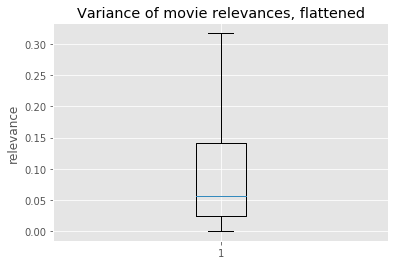

In [18]:
plt.boxplot(M.flatten(),0,'')
plt.title("Variance of movie relevances, flattened")
plt.ylabel("relevance")
plt.show()

We can see that the mean value of the relevances is close to 0.05 which is quite low. The variance shows that even if there are a few higher relevances most of the relevances are close and a little below 0.05. 
The relevance denotes the relevance of the tagg? so the tag relevances seem to be very low

####  Plot the variance of each dimension (represented by tags) across all movies.

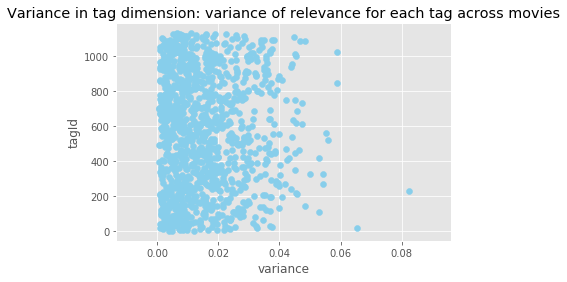

In [19]:
#variances along axis 0 - tag dimension
M1_var=np.var(M,axis=1)
plt.scatter(M1_var,range(1,len(M1_var)+1),facecolor='skyblue')
plt.title("Variance in tag dimension: variance of relevance for each tag across movies")
plt.ylabel("tagId")
plt.xlabel("variance")
plt.show()

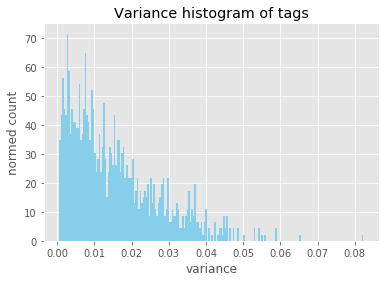

In [20]:
#import matplotlib
plt.hist(M1_var, bins=200,normed=1,facecolor='skyblue')
plt.title("Variance histogram of tags")
plt.ylabel("normed count")
#_,ax1=plt.subplots()
#ax1.set_xscale('log')
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel("variance")
plt.show()

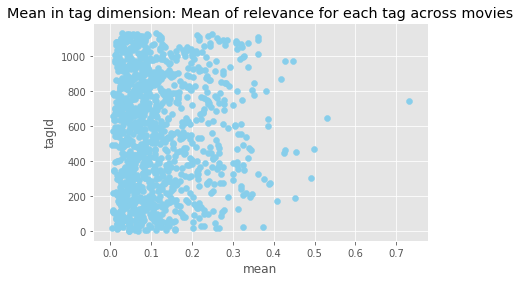

In [21]:
M1_mean=np.mean(M,axis=1)
plt.scatter(M1_mean,range(1,len(M1_mean)+1),facecolor='skyblue')
plt.title("Mean in tag dimension: Mean of relevance for each tag across movies")
plt.ylabel("tagId")
plt.xlabel("mean")
plt.show()

The variances are rather small, so it seems that most of the tags have approximately the same relevance in each movie. 
As the variances are low the means are quite meaningful. They show that there are some tags with quite high relevance across all movies.

In [22]:
var_indx=np.argsort(M1_var) #sort indices
var_high=[tag2name[indx+1] for indx in var_indx[-7:] ] 
var_low=[tag2name[indx+1] for indx in var_indx[:7] ] 
print ("Tags with highest variance: ", var_high)
print ("Tags with lowest variance: ", var_low) 

Tags with highest variance:  ['criterion', 'intimate', 'horror', 'relationships', 'tense', 'action', 'comedy']
Tags with lowest variance:  ['neil gaiman', 'figure skating', 'hannibal lecter', 'neo-nazis', 'circus', 'truman capote', 'easily confused with other movie(s) (title)']


We can see that the tags with the highest variance are very broad and thus ambigous.
Tags with the lowest relevance variance are very specific.

In [23]:
mean_indx=np.argsort(M1_mean) #sort indices
print(mean_indx[-7:])
mean_high=[tag2name[indx+1] for indx in mean_indx[-7:] ] 
mean_low=[tag2name[indx+1] for indx in mean_indx[:7] ] 
print ("Tags with highest relevance mean: ", mean_high)
print ("Tags with lowest relevance mean: ", mean_low)

[971 187 451 301 467 645 741]
Tags with highest relevance mean:  ['storytelling', 'catastrophe', 'good soundtrack', 'dialogue', 'great ending', 'mentor', 'original']
Tags with lowest relevance mean:  ['hannibal lecter', 'aardman', 'claymation', 'beatles', 'batman', 'james bond', 'baseball']


The tags with the highest relevance mean over all movies must be important to users for describing a movie in general while the low mean tags are usuallynot very important when describing a movie.

In [24]:
#variances along axis 0 - Movie dimension
#not important
"""M0_var=np.var(M,axis=0)
plt.scatter(M0_var,range(1,len(M0_var)+1),facecolor='skyblue')
plt.title("Variance in movie dimension: variance of relevance of each movie for all tags")
plt.ylabel("tag?")
plt.xlabel("variance")
plt.show()"""

'M0_var=np.var(M,axis=0)\nplt.scatter(M0_var,range(1,len(M0_var)+1),facecolor=\'skyblue\')\nplt.title("Variance in movie dimension: variance of relevance of each movie for all tags")\nplt.ylabel("tag?")\nplt.xlabel("variance")\nplt.show()'

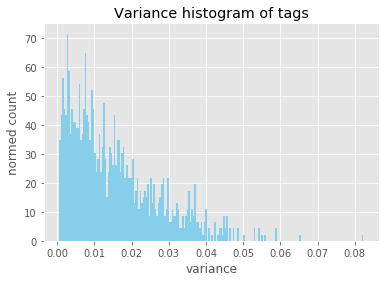

In [25]:
#import matplotlib
plt.hist(M1_var, bins=200,normed=1,facecolor='skyblue')
plt.title("Variance histogram of tags")
plt.ylabel("normed count")
#_,ax1=plt.subplots()
#ax1.set_xscale('log')
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel("variance")
plt.show()

This plot shows a histogram of the variances of tag relevance across movies. We can see that most of them are very low. This is in accordance with the previous histogram and the scattered diagram.

#### Plot the eigenvalues of the M×M covariance matrix

First creating the covariance matrix

In [27]:
#standardize by subtracting the mean
#also normalize?
M_zeromean=M-np.array([M1_mean]).T
M_cov=np.cov(M_zeromean)

In [28]:
M_cov

array([[ 0.00490042,  0.00327346, -0.00030115, ...,  0.00016838,
        -0.00016172, -0.00014599],
       [ 0.00327346,  0.00374098, -0.00023234, ...,  0.00011866,
        -0.00015645, -0.00014514],
       [-0.00030115, -0.00023234,  0.01184989, ...,  0.00130349,
        -0.00112118, -0.00035662],
       ..., 
       [ 0.00016838,  0.00011866,  0.00130349, ...,  0.0188282 ,
        -0.00114338, -0.00032847],
       [-0.00016172, -0.00015645, -0.00112118, ..., -0.00114338,
         0.01105378,  0.00659333],
       [-0.00014599, -0.00014514, -0.00035662, ..., -0.00032847,
         0.00659333,  0.00658031]])

In [29]:
eigvalues,eigvectores = np.linalg.eigh(M_cov)

In [30]:
eigval_list=eigvalues.tolist()
eigval_list.reverse()

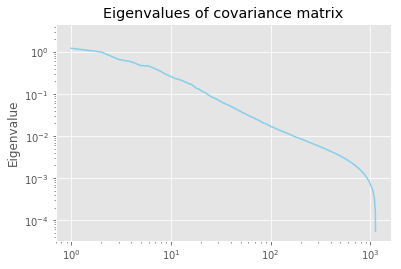

In [31]:
plt.loglog(eigval_list,color="skyblue")
plt.title("Eigenvalues of covariance matrix")
plt.ylabel("Eigenvalue")
plt.show()

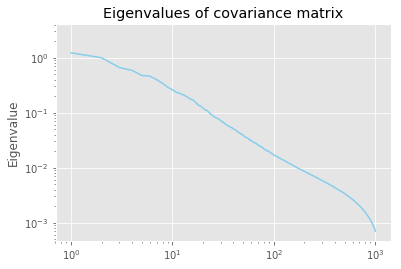

In [32]:
plt.loglog(eigval_list[:1007],color="skyblue")
plt.title("Eigenvalues of covariance matrix")
plt.ylabel("Eigenvalue")
plt.show()

Almost all eigenvalues are very small. Only approximately 20 eigenvalues are bigger than 0.1. That is the reason why we can capture a lot of information using only a few dimensions in the part below

####  Explain the implications for dimensionality reduction.

E.g. how many principal directions do you need to capture 2/3 of the variability in the data

In [33]:
cumulus=np.cumsum(eigval_list)/np.sum(eigvalues)
important_principal_directions= [n for n,i in enumerate(cumulus) if i>(2./3.)]
important_principal_directions[0]

36

We need 41 principal directions to capture 2/3 of the variability in the data

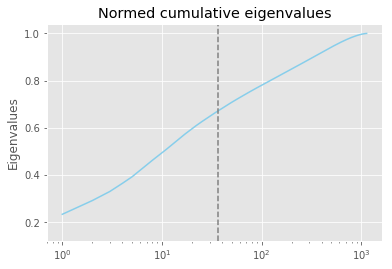

In [34]:
plt.semilogx(cumulus,color="skyblue")
plt.title("Normed cumulative eigenvalues")
plt.ylabel("Eigenvalues")
plt.axvline(important_principal_directions[0],linestyle="dashed",color="grey")

With the first 41 eigenvalues (and the corresponding principal directions) we can capture 2/3 of the data variability. So we can model the original dimension space that is bigger than 1000 with only 41 dimensions and still keep 2/3 of the information from the original data. This shows that we can use PCA very well for dimensionality reduction because it preserves  a lot of information while only using a few most important principal components.


---
## Exercise 3.2 - Concept Space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.

•  Whatconcepts would you use to describe these dimensions?


In [35]:
#
eigval_five=eigval_list[:5]
print(eigval_five)
#eigenvectores are reversed
eigvec_five_rev=eigvectores[:,-5:].T
eigvec_five=eigvec_five_rev[::-1]

[2.7533774797813497, 1.2214710425886668, 0.9960515193084873, 0.662175500207405, 0.5857297851139419]


In [37]:
for i in range(5):  
    indices = np.argsort(eigvectores[:, -(i+1)])
    lowest_10 = indices[:10]
    top_10 = indices[-10:][::-1]
    print('\n\033[1mEigenvector {}\033[1m\n'.format(i+1))
    print('             \033[1m highest | lowest\033[0m')
    for top, low in zip(top_10, lowest_10):
        print("{: >20} {: >20}".format(tag2name[top+1], tag2name[low+1])) #Do I need to put plus one here, I think so?




Eigenvector 1

              highest | lowest
               talky          predictable
   social commentary    so bad it's funny
           criterion             bad plot
        imdb top 250                silly
        great acting            silly fun
               drama             horrible
oscar (best directing)            franchise
               bleak                 lame
            dramatic           big budget
      cinematography               comedy

Eigenvector 2

              highest | lowest
            intimate               action
       relationships      special effects
           criterion           big budget
         melancholic                chase
          loneliness           fast paced
         golden palm             suspense
          meditative          good action
           art house                 plot
          melancholy                pg-13
              sexual        action packed

Eigenvector 3

              highest | lowest
           feel-g

proposed concept spaces
first principal direction("serious" oscar-level moives v.s. silly / fun movies): seriousness, subject gravity
Second principal direction(sentiments v.s. action): budget, special effect, sentimentality
Third principal direction (heartwarming v.s. disturbing moview): atmosphere, disturbance, creepiness
Fourth principal direction (visually imaginative and pleasing vs. realistic criminality) concept space: realness, visual-style
Fifth principal direction (mysteries vs. comedy) concept space: tension, atmosphere 

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal directions and save it to disk. This will be used later for the clustering exercise.

In [38]:
import pickle

eigenspace = np.dot(eigvec_five, M_zeromean)
projection = np.dot(M_zeromean, eigenspace.T)

tags_mapped = {}

for key, value in tag2name.items():
    tags_mapped[value] = projection[key-1,:]
    
#to pickle
with open('tag_embedding.pickle', 'wb') as handle:
    pickle.dump(projection, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tags_mapped.pickle', 'wb') as handle:
    pickle.dump(tags_mapped, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
## Exercise 3.3 - Movie visualization



In [39]:
#get data
with open('selected-movies.pickle', 'rb') as handle:
    selected_movies = pickle.load(handle, encoding='utf-8') # encoding='latin1'

In [40]:
indx = []
names = []
ratings = []
for row in selected_movies:
    movie_id = row[0]
    movie_name= row[1]
    movie_rating = row[2]
    #matrix form 3.1
    movie_index = movieId_matrix.index(movie_id)
    indx.append(movie_index)
    names.append(movie_name)
    ratings.append(movie_rating)

In [55]:
selected_M = M[:,indx]
print (selected_M.shape)

pca_2d = eigvec_five.T[:,:2]
print(pca_2d.shape)

projected = pca_2d.T.dot(selected_M)
print(projected.shape)

(1128, 37)
(1128, 2)
(2, 37)


#### Project the movies of selected-movies.pickle on the first two principal directions.

• Create an interactive plot that displays the 2D-projection of the movies using
bokeh and its hove tool. Color the nodes by their Rotten Tomatoes score.


This score corresponds to the percentage of newspaper reviews that rate the movie favorably. See
https:
//www.rottentomatoes.com/


In [53]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib as mpl
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool
output_notebook()


output_file("selected_ratings.html")

source = ColumnDataSource(
        data={
            "x": projected[0,:],
            "y":projected[1,:],
            "desc":names,
            "rating":ratings,
            #color depending on rating red, bad , green good
            "color":[
    "#%02x%02x%02x" % (255-int(r), int(g), 0) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(ratings))
]
        }
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Name", "@desc"),
            ("Rating", "@rating"),
        ]
    )

p = figure(plot_width=400, plot_height=400, tools=[hover],
           title="Visualization of selected movies")
p.xaxis.axis_label = 'First Principal Component'
p.yaxis.axis_label = 'Second Principal Component'

p.circle(x='x',y= 'y', fill_alpha=0.2, color="color", size=10, source=source)

show(p)

Loading BokehJS ...

Based on your knowledge of these movies and information that you can get from the web, explain the coordinates of a few of the movies.

Movies are globally gathered according to their genres. movies such as videodrome, Ichi the killer that belongs to the same genre are closer to each other. 



How do the PCA directions correlate with the Rotten Tomatoes score?

There seems to be some correlation betweewn the Rotten Tomatoes score and the first principle direction: movies with higher value in the first principle direction would likely have higher Rotten Tomato scores. 
Plausible reason: as we have seen in 3.2, movies with higher values in the 1st principle direction are more likely to be Oscar-level movies and understandably higher RT scores, and vice versa.

Try projecting the movies on subsequent principal directions. Does it make sense based on your knowledge of these movies? (Not needed for the hand-in)